In [1]:
#import necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
# Step 1: Download the MNIST dataset
torchvision.datasets.MNIST(root='./data', train=True, download=True)
torchvision.datasets.MNIST(root='./data', train=False, download=True)

# Step 2: Load the raw MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 15.9MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 537kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.78MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.90MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



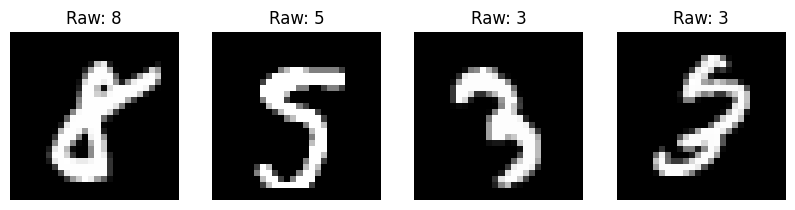

In [3]:
# Visualize the datasets
def show_images(images, labels, label_header="True"):
    figure = plt.figure(figsize=(10, 10))
    rows, cols = 1, 4
    for i in range(1, rows*cols+1):
        figure.add_subplot(rows, cols, i)
        plt.axis(False)
        plt.title(f"{label_header}: {labels[i-1].item()}")
        plt.imshow(images[i-1].permute(1, 2, 0), cmap='gray')

    plt.show()

# Get a batch of images and show
images, labels = next(iter(trainloader))
show_images(images, labels, label_header="Raw")

In [4]:
# Step 3: Preprocessing Step: Normalization and Data Augmentation
transform_train = transforms.Compose([
    transforms.RandomRotation(10),  # Randomly rotate the image by 10 degrees
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  # Random translation
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to range [-1, 1]
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize the same way for test set
])

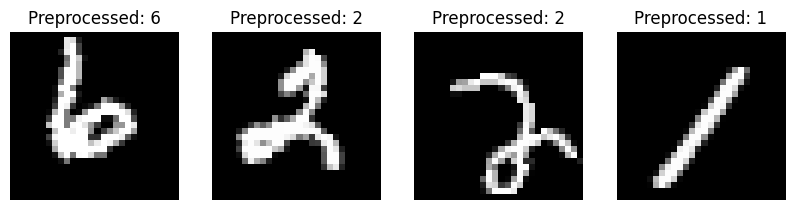

In [5]:
# Step 4: Load the MNIST dataset with preprocessing applied
trainset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Visualize Some Preprocessed Images
preprocessed_images, preprocessed_labels = next(iter(trainloader))
show_images(preprocessed_images, preprocessed_labels, label_header="Preprocessed")

In [7]:
# Mlp model
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [8]:
# Step 1: Define the MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # Flatten input (28x28) to 784
        self.flatten = nn.Flatten()
        # Define MLP layers
        self.fc1 = nn.Linear(28*28, 256)  # First fully connected layer
        self.fc2 = nn.Linear(256, 128)    # Second fully connected layer
        self.fc3 = nn.Linear(128, 64)     # Third fully connected layer
        self.fc4 = nn.Linear(64, 10)      # Output layer (10 classes)
        self.relu = nn.ReLU()             # ReLU activation function

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)  # No activation in the last layer (we'll use CrossEntropyLoss which combines softmax)
        return x

# Step 2: Initialize model, loss function, and optimizer
model = MLP()
criterion = nn.CrossEntropyLoss()  # Cross entropy loss combines softmax and loss calculation
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam optimizer

In [9]:
# Step 3: Training function
def train(model, trainloader, criterion, optimizer, epochs=20):
    model.train()  # Set the model to training mode
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in trainloader:
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Print statistics
        epoch_loss = running_loss / len(trainloader)
        accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Training Accuracy: {accuracy:.2f}%,")

In [10]:
# Step 4: Evaluation function
def evaluate(model, testloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():  # Disable gradient calculation for inference
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())  # Convert lists to numpy arrays
            all_preds.extend(predicted.cpu().numpy())

     # Step 5: Compute evaluation metrics
    accuracy = accuracy_score(all_labels, all_preds) * 100
    precision = precision_score(all_labels, all_preds, average="weighted") * 100
    recall = recall_score(all_labels, all_preds, average="weighted") * 100
    f1 = f1_score(all_labels, all_preds, average="weighted") * 100

    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}%")
    print(f"Recall: {recall:.2f}%")
    print(f"F1 Score: {f1:.2f}%")


In [ ]:
# Step 6: Train the model
train(model, trainloader, criterion, optimizer, epochs=20)

# Step 7: Evaluate the model on the test set
evaluate(model, testloader)

# save the model weights
model_1 = MLP()  # Create the model instance
torch.save(model_1 ,"mlp_mnist_weights.pth")
print("Mlp Model weights saved successfully.")


Epoch [1/20], Loss: 0.2570, Training Accuracy: 91.98%,
Epoch [2/20], Loss: 0.2157, Training Accuracy: 93.15%,
Epoch [3/20], Loss: 0.1907, Training Accuracy: 93.89%,
Epoch [4/20], Loss: 0.1749, Training Accuracy: 94.37%,
Epoch [5/20], Loss: 0.1614, Training Accuracy: 94.88%,
Epoch [6/20], Loss: 0.1570, Training Accuracy: 94.94%,
Epoch [7/20], Loss: 0.1452, Training Accuracy: 95.41%,
Epoch [8/20], Loss: 0.1430, Training Accuracy: 95.53%,
Epoch [9/20], Loss: 0.1420, Training Accuracy: 95.50%,
Epoch [10/20], Loss: 0.1297, Training Accuracy: 95.95%,
Epoch [11/20], Loss: 0.1282, Training Accuracy: 95.88%,
Epoch [12/20], Loss: 0.1219, Training Accuracy: 96.16%,
Epoch [13/20], Loss: 0.1207, Training Accuracy: 96.16%,
Epoch [14/20], Loss: 0.1147, Training Accuracy: 96.30%,
Epoch [15/20], Loss: 0.1135, Training Accuracy: 96.46%,
Epoch [16/20], Loss: 0.1135, Training Accuracy: 96.45%,
Epoch [17/20], Loss: 0.1104, Training Accuracy: 96.53%,
Epoch [18/20], Loss: 0.1061, Training Accuracy: 96.66%,
E

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional layer
        # 1 input channel (grayscale), 16 filters, kernel size 3x3, and padding of 1 to maintain size
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        # Pooling layer to reduce spatial dimensions
        self.pool = nn.MaxPool2d(2, 2)
        # Fully connected layer
        # Input size is determined by the number of filters (16) and reduced image size (14x14 after pooling)
        self.fc1 = nn.Linear(16 * 14 * 14, 10)  # Output is 10 classes (digits 0-9)

    def forward(self, x):
        # Apply the convolutional layer followed by ReLU activation and max pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Flatten the output of the convolutional layer to pass it into the fully connected layer
        x = x.view(-1, 16 * 14 * 14)
        # Apply the fully connected layer
        x = self.fc1(x)
        return x

# Initialize the model, loss function, and optimizer
cnn_model = CNN()
criterion = nn.CrossEntropyLoss()  # Cross entropy for classification
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)  # Adam optimizer


In [12]:
# Training function
def train_cnn(model, trainloader, criterion, optimizer, epochs=20):
    model.train()  # Set the model to training mode
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in trainloader:
            # Zero the gradients from the previous step
            optimizer.zero_grad()
            # Forward pass: compute predictions
            outputs = model(images)
            # Compute loss
            loss = criterion(outputs, labels)
            # Backward pass: compute gradients
            loss.backward()
            # Update the model parameters
            optimizer.step()

            # Track loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate epoch loss and accuracy
        epoch_loss = running_loss / len(trainloader)
        accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Training Accuracy: {accuracy:.2f}%")

In [13]:
# Evaluation function
def evaluate_cnn(model, testloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():  # Disable gradient calculation for inference
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Calculate evaluation metrics
    accuracy = accuracy_score(all_labels, all_preds) * 100
    precision = precision_score(all_labels, all_preds, average="weighted") * 100
    recall = recall_score(all_labels, all_preds, average="weighted") * 100
    f1 = f1_score(all_labels, all_preds, average="weighted") * 100

    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}%")
    print(f"Recall: {recall:.2f}%")
    print(f"F1 Score: {f1:.2f}%")

In [ ]:
# Train the CNN model
train_cnn(cnn_model, trainloader, criterion, optimizer, epochs=20)

# Evaluate the CNN model on the test set
evaluate_cnn(cnn_model, testloader)

# save the model weights
model_2 = CNN()  # Create the model instance
torch.save(model_2 ,"cnn_mnist_weights.pth")
print("Cnn Model weights saved successfully.")

Epoch [1/20], Loss: 0.5278, Training Accuracy: 84.32%
Epoch [2/20], Loss: 0.2757, Training Accuracy: 91.60%
Epoch [3/20], Loss: 0.2459, Training Accuracy: 92.52%
Epoch [4/20], Loss: 0.2295, Training Accuracy: 92.91%
Epoch [5/20], Loss: 0.2183, Training Accuracy: 93.30%
Epoch [6/20], Loss: 0.2096, Training Accuracy: 93.71%
Epoch [7/20], Loss: 0.2002, Training Accuracy: 94.01%
Epoch [8/20], Loss: 0.1930, Training Accuracy: 94.20%
Epoch [9/20], Loss: 0.1882, Training Accuracy: 94.36%
Epoch [10/20], Loss: 0.1815, Training Accuracy: 94.48%
Epoch [11/20], Loss: 0.1784, Training Accuracy: 94.58%
Epoch [12/20], Loss: 0.1729, Training Accuracy: 94.77%
Epoch [13/20], Loss: 0.1694, Training Accuracy: 94.91%
Epoch [14/20], Loss: 0.1637, Training Accuracy: 95.01%
Epoch [15/20], Loss: 0.1611, Training Accuracy: 95.12%
Epoch [16/20], Loss: 0.1570, Training Accuracy: 95.22%
Epoch [17/20], Loss: 0.1554, Training Accuracy: 95.34%
Epoch [18/20], Loss: 0.1544, Training Accuracy: 95.44%
Epoch [19/20], Loss

In [14]:
#import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [15]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # Convolutional and pooling layers
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)  # Input: 28x28, Output: 28x28
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)  # Input: 28x28, Output: 14x14
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)  # Input: 14x14, Output: 10x10
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)  # Input: 10x10, Output: 5x5

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # Flattened to 16x5x5, Output: 120
        self.fc2 = nn.Linear(120, 84)  # Output: 84
        self.fc3 = nn.Linear(84, 10)  # Output: 10 (for 10 digits)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 16 * 5 * 5)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No activation on the final layer
        return x


In [16]:
# Initialize LeNet-5 model
model_3 = LeNet5()
criterion = nn.CrossEntropyLoss()  # Cross entropy loss for multi-class classification
optimizer = optim.Adam(model_3.parameters(), lr=0.001)  # Adam optimizer

# Training function
def train_lenet5(model, trainloader, criterion, optimizer, epochs=20):
    model.train()    # Set the model to training mode
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in trainloader:
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)
            loss.backward()  # Backward pass and optimization
            optimizer.step()
            running_loss += loss.item()  # Statistics
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()



       # Print statistics
        epoch_loss = running_loss / len(trainloader)
        accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Training Accuracy: {accuracy:.2f}%")


In [17]:
# Evaluation function
def evaluate_lenet5(model, testloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():  # Disable gradient calculation for inference
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())  # Convert lists to numpy arrays
            all_preds.extend(predicted.cpu().numpy())

    # Compute evaluation metrics
    accuracy = accuracy_score(all_labels, all_preds) * 100
    precision = precision_score(all_labels, all_preds, average="weighted") * 100
    recall = recall_score(all_labels, all_preds, average="weighted") * 100
    f1 = f1_score(all_labels, all_preds, average="weighted") * 100

    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}%")
    print(f"Recall: {recall:.2f}%")
    print(f"F1 Score: {f1:.2f}%")


In [ ]:
# Train the LeNet-5 model
train_lenet5(model_3, trainloader, criterion, optimizer, epochs=20)

# Evaluate the LeNet-5 model on the test set
evaluate_lenet5(model_3, testloader)

torch.save(model_3.state_dict(), "lenet5_weights.pth")
print("Lenet5 Model weights saved successfully.")

Epoch [1/20], Loss: 0.0332, Training Accuracy: 98.94%
Epoch [2/20], Loss: 0.0320, Training Accuracy: 98.97%
Epoch [3/20], Loss: 0.0325, Training Accuracy: 98.95%
Epoch [4/20], Loss: 0.0326, Training Accuracy: 98.93%
Epoch [5/20], Loss: 0.0300, Training Accuracy: 99.10%
Epoch [6/20], Loss: 0.0310, Training Accuracy: 99.02%
Epoch [7/20], Loss: 0.0308, Training Accuracy: 99.00%
Epoch [8/20], Loss: 0.0309, Training Accuracy: 99.04%
Epoch [9/20], Loss: 0.0285, Training Accuracy: 99.12%
Epoch [10/20], Loss: 0.0286, Training Accuracy: 99.11%
Epoch [11/20], Loss: 0.0282, Training Accuracy: 99.11%
Epoch [12/20], Loss: 0.0285, Training Accuracy: 99.10%
Epoch [13/20], Loss: 0.0268, Training Accuracy: 99.16%
Epoch [14/20], Loss: 0.0265, Training Accuracy: 99.13%
Epoch [15/20], Loss: 0.0269, Training Accuracy: 99.15%
Epoch [16/20], Loss: 0.0266, Training Accuracy: 99.15%
Epoch [17/20], Loss: 0.0257, Training Accuracy: 99.16%
Epoch [18/20], Loss: 0.0253, Training Accuracy: 99.21%
Epoch [19/20], Loss

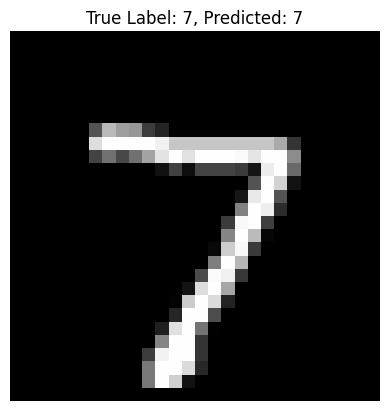

In [35]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_sample_image(model, testloader):
    # Set the model to evaluation mode
    model.eval()

    # Get a single batch of data from the testloader
    images, labels = next(iter(testloader))

    # Ensure images and labels are on the CPU
    images, labels = images.cpu(), labels.cpu()

    # Get the model's prediction for the first image in the batch
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    # Select the first image in the batch
    image = images[0]  # The first image in the batch
    true_label = labels[0].item()  # Get the true label (first element in the batch)
    pred_label = predicted[0].item()  # Get the predicted label (first element in the batch)

    # Convert the image from PyTorch tensor to NumPy array for visualization
    image = image.numpy()  # Convert to numpy array (channel, height, width)

    # Handle grayscale image (LeNet input is typically grayscale, so we use the first channel)
    image = image[0]  # We only need the first channel (grayscale image)

    # Plot the image and display the true and predicted labels
    plt.imshow(image, cmap='gray')  # Display in grayscale
    plt.title(f"True Label: {true_label}, Predicted: {pred_label}")
    plt.axis('off')  # Hide axis
    plt.show()

# Visualize a sample image
visualize_sample_image(model_3, testloader)
